### Complete Example of developing a CNN application including saving the model and predicting on new data ###

In [1]:
# Import required modules

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.dataset import random_split
import torchvision.transforms as transforms

from torchsummary import summary  # pip install torchsummary

import os

from skimage.io import imsave, imread
from skimage import io,transform
from skimage.color import rgb2gray

import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(1)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Which is the root directory in which my image files located?

img_path = '/Users/jagannathrao/Nextcloud/UGA_2019/INFO_4150/INFO_4150_Spring_2022/Datasets/Mnist_Image_Data/Images'

In [4]:
# Which directories are there in the img path which contain my inages?

for root, dirs, files in os.walk(img_path, topdown=False):
        for name in dirs:
              print(os.path.join(root, name))
              

/Users/jagannathrao/Nextcloud/UGA_2019/INFO_4150/INFO_4150_Spring_2022/Datasets/Mnist_Image_Data/Images/test
/Users/jagannathrao/Nextcloud/UGA_2019/INFO_4150/INFO_4150_Spring_2022/Datasets/Mnist_Image_Data/Images/train


In [5]:
# Read in the train and test labels from .csv files

train_labels =  pd.read_csv('/Users/jagannathrao/Nextcloud/UGA_2019/INFO_4150/INFO_4150_Spring_2022/Datasets/Mnist_Image_Data/train.csv')

test_labels =  pd.read_csv('/Users/jagannathrao/Nextcloud/UGA_2019/INFO_4150/INFO_4150_Spring_2022/Datasets/Mnist_Image_Data/test.csv')

print(f"Label file contains image filename and the corresponding label:\n\n{train_labels.head()}\n")


Label file contains image filename and the corresponding label:

  filename  label
0    0.png      4
1    1.png      9
2    2.png      1
3    3.png      7
4    4.png      3



Image filename:
/Users/jagannathrao/Nextcloud/UGA_2019/INFO_4150/INFO_4150_Spring_2022/Datasets/Mnist_Image_Data/Images/train/0.png

Image Shape(28, 28, 4)

Single channel image shape: (28, 28, 1)


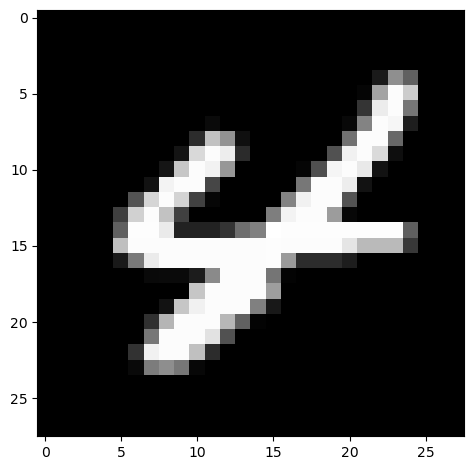

In [6]:
# Let us check a single image file using the destination information
img = os.path.join(img_path+'/train/'+train_labels['filename'][0])
print(f"Image filename:\n{img}")

# Display image
img = plt.imread(img)
print(f"\nImage Shape{img.shape}")

# We need omly one channel as represntative of a image
img =  img[:,:,:1]
print(f"\nSingle channel image shape: {img.shape}")

# Display the image
io.imshow(img)
plt.show()

In [7]:
# Create the dataset class to read in data by inheriting the PyTorch Dataset class
# The dataset class should return 1 datapoint as a tuple - an image and its label

class mnist(Dataset):

    def __init__(self, img_path,labels,transforms=None):
        self.img_path = img_path
        self.labels = labels
        self.transforms = transforms
        

    def __len__(self):
        return len(self.labels)


    def __getitem__(self,idx):

        img = os.path.join(self.img_path+self.labels['filename'][idx])
        img = io.imread(img)
        
        img = img[:,:,:1] # Read a single channel only
    
        img = img/255.0   # Normalize or Feature Scale data
        img = np.moveaxis(img,2,0)
        
        label = self.labels['label'][idx]
        label = label.astype('float')
        label = np.array(label).reshape(-1,1)
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return torch.from_numpy(img),torch.from_numpy(label)

In [8]:
# Instantiate the train and test data objects from the mnist class just created
train_data =  mnist(img_path+'/train/',train_labels)
test_data =  mnist(img_path+'/test/',test_labels)

# Amount of data - train and test while testing the __len__ method
print(train_data.__len__(),test_data.__len__())

49000 100


Image Shape as read in:torch.Size([1, 28, 28])
Image Type:<class 'torch.Tensor'>

The label for this image is: tensor([[9.]], dtype=torch.float64)

Image Shape after moving axis:(28, 28)
Label Shape:torch.Size([1, 1])



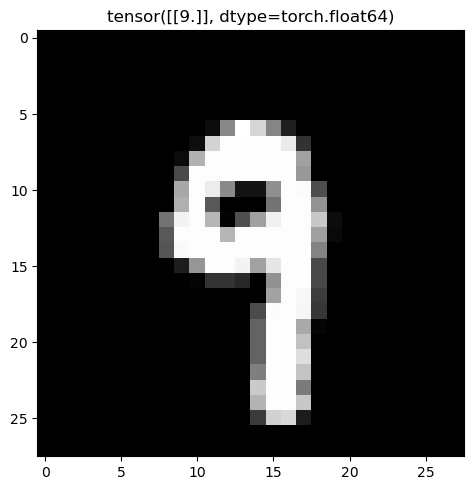

In [9]:
# Look at an image while testing the __getitem__ method

# Use "get item" method to get one data point from any index (idx = 1 in this example)
image1,label1 = train_data.__getitem__(1)
print(f"Image Shape as read in:{image1.shape}\nImage Type:{type(image1)}\n")
print(f"The label for this image is: {label1}\n")

image1 = np.array(image1)        #1,28,28
image1 = np.moveaxis(image1,0,2) #28,28,1
image1 = np.squeeze(image1)      #28,28

print(f"Image Shape after moving axis:{image1.shape}\nLabel Shape:{label1.shape}\n")

io.imshow(image1)
plt.title(label1)
plt.show()


In [11]:
# Dataloader to get mini batched of data

train_loader = DataLoader(dataset=train_data, batch_size=64,shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=20,shuffle=False)

#next(iter(train_loader))


In [12]:
# let us check if the mini batch is being loaded everytime we call train loader

for i , (x_batch,y_batch) in enumerate(train_loader):     
    break

x_batch.shape,y_batch.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 1, 1]))

In [13]:
# Build the CNN model architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5,padding=2)
        self.conv2 = nn.Conv2d(32,64, kernel_size=5,padding=2)
        self.dropout = nn.Dropout2d(p=0.2)
        self.conv3 = nn.Conv2d(64,128, kernel_size=5,padding=2)
        self.fc1 = nn.Linear(7*7*128, 1000)
        self.fc2 = nn.Linear(1000,50)
        self.fc3 = nn.Linear(50, 10)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.relu(self.conv3(x))
        
        x = x.view(-1, 7*7*128)
        
        x = self.relu(self.fc1(x))
        
        # Dropout will work only during training with that comment
        if self.training:
            x = self.dropout(x) 
        x = self.fc2(x)
        x = self.fc3(x)
        return x 

In [14]:
# Print model summary

model = Net()   # Instantiate the model object
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
         Dropout2d-5           [-1, 64, 14, 14]               0
              ReLU-6           [-1, 64, 14, 14]               0
         MaxPool2d-7             [-1, 64, 7, 7]               0
            Conv2d-8            [-1, 128, 7, 7]         204,928
              ReLU-9            [-1, 128, 7, 7]               0
           Linear-10                 [-1, 1000]       6,273,000
             ReLU-11                 [-1, 1000]               0
        Dropout2d-12                 [-1, 1000]               0
           Linear-13                   [-1, 50]          50,050
           Linear-14                   

In [15]:
# We can also inspect its parameters using its state_dict
#print(model.state_dict())

# Fix learning rate, number of epochs
lr = 0.001
n_epochs = 1

# Loss function for multiclass classification
loss_fn = nn.CrossEntropyLoss()

log_interval = 10 # Variable used to display the gradient descent progress

# Instantiate the optimizer with Adam for gradient descent
optimizer = optim.Adam(model.parameters(),lr=lr)

In [16]:
# Storage containers for capturing loss values 

train_losses = []
train_counter = []

test_losses = []
test_counter = [i*len(train_data) for i in range(n_epochs + 1)]

In [17]:
# Train step function

def train(epoch):
    model.train()
    
    # Read mini batch of training from dataloader and assign read in values to variables
    for batch_idx, (data, target) in enumerate(train_loader):
        data,target = data.float(),target.long()
        #print(data,target)
        
        # Clear the cache from past gradient values
        optimizer.zero_grad()
        
        # Predict on training data
        output = model(data)
        
        # Remove the additional dimension
        output = torch.squeeze(output) 
        target = torch.squeeze(target)
        #print(output.shape,target.shape)
        
        # Compute loss, back propogate and update weights
        loss = loss_fn(output,target)
        loss.backward()
        optimizer.step()
        
        # Bunch of code to print the progress every 10 epochs
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_data)} {100. * batch_idx* len(data) / len(train_data):.0f}%)]\tLoss: {loss.item():.6f}")
            
            # Store counter and loss values
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_data)))
            
            # Save the model and the weight parameters
            torch.save(model.state_dict(), 'model.pth')
            torch.save(optimizer.state_dict(), 'results.pth')

In [18]:
# Test step function

def test():
    model.eval()
    
    # Create variable to compute accuracy
    test_loss = 0
    correct = 0
    
    # Make sure gradient descent is not happening
    with torch.no_grad():
        for data, target in test_loader:
            data,target = data.float(),target.long()
            output = model(data)
            
            # Remove additional dimension
            output = torch.squeeze(output)
            target = torch.squeeze(target)
            #print(output.shape,target.shape)
            
            # Compute loss and add
            test_loss += loss_fn(output, target).item()
            
            # Store the predicted value
            pred = output.data.max(1, keepdim=True)[1]
            
            # Compute accuracy
            correct += pred.eq(target.data.view_as(pred)).sum()
    # Compute average test loss 
    test_loss /= len(test_loader)
    
    # Store loss values
    test_losses.append(test_loss)
    
    print(f"\nTest set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_data)} ({100. * correct / len(test_data):.0f}%)")

In [19]:
# Include evaluation requirements

import time
from datetime import timedelta

start_time = time.time()

# Perform lots of computations.

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    
elapsed_time_secs = time.time() - start_time

msg = "Execution took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))

print(msg)


Test set: Avg. loss: 2.3026, Accuracy: 11/100 (11%)
Train Epoch: 1 [0/49000 0%)]	Loss: 2.313699
Train Epoch: 1 [640/49000 1%)]	Loss: 1.391179
Train Epoch: 1 [1280/49000 3%)]	Loss: 0.667129
Train Epoch: 1 [1920/49000 4%)]	Loss: 0.649229
Train Epoch: 1 [2560/49000 5%)]	Loss: 0.593496
Train Epoch: 1 [3200/49000 7%)]	Loss: 0.447683
Train Epoch: 1 [3840/49000 8%)]	Loss: 0.218174
Train Epoch: 1 [4480/49000 9%)]	Loss: 0.115202
Train Epoch: 1 [5120/49000 10%)]	Loss: 0.419818
Train Epoch: 1 [5760/49000 12%)]	Loss: 0.373359
Train Epoch: 1 [6400/49000 13%)]	Loss: 0.287552
Train Epoch: 1 [7040/49000 14%)]	Loss: 0.193404
Train Epoch: 1 [7680/49000 16%)]	Loss: 0.092321
Train Epoch: 1 [8320/49000 17%)]	Loss: 0.111619
Train Epoch: 1 [8960/49000 18%)]	Loss: 0.105215
Train Epoch: 1 [9600/49000 20%)]	Loss: 0.083426
Train Epoch: 1 [10240/49000 21%)]	Loss: 0.106194
Train Epoch: 1 [10880/49000 22%)]	Loss: 0.122379
Train Epoch: 1 [11520/49000 24%)]	Loss: 0.144109
Train Epoch: 1 [12160/49000 25%)]	Loss: 0.33

Text(0, 0.5, 'negative log likelihood loss')

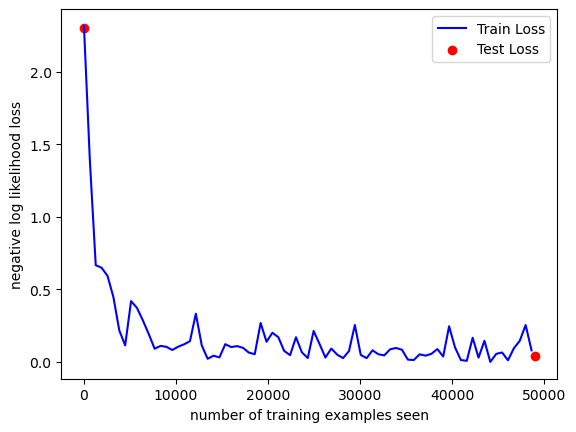

In [20]:
# Plot the loss curve

fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [21]:
# Function to predict on new images from trained model

read_in_images = []  # To store the images read in

def classify(model,image,classes,count):
    image = io.imread(image)
    print(image.shape)
    read_in_images.append(image)
    io.imshow(read_in_images[count])
    plt.show()
    count += 1
    
    # Transform to correct shape
    image = transform.resize(image,(28,28))
    
    # Check if image has more than 2 channels (RGB type) and if yes convert to grayscale
    if len(image.shape) > 2:
        image = rgb2gray(image)
    print(image.shape)
    #image = image/255
    
    # Put in eval mode
    model = model.eval()
    image = torch.from_numpy(image) # Convert to torch tensor
    image = image.float() # of type float
    
    image = image.unsqueeze(0) # Add additional dimension to represent batch sie of 1
    
    # Predict
    output = model(image)
    print(f"Predictions:\n{output.data}\n")
    
    # Pick the value with the highes probability score in the output
    _,predicted = torch.max(output.data,1)
    print(f"Predicted Number:{classes[predicted.item()]}\n")

(224, 225, 3)


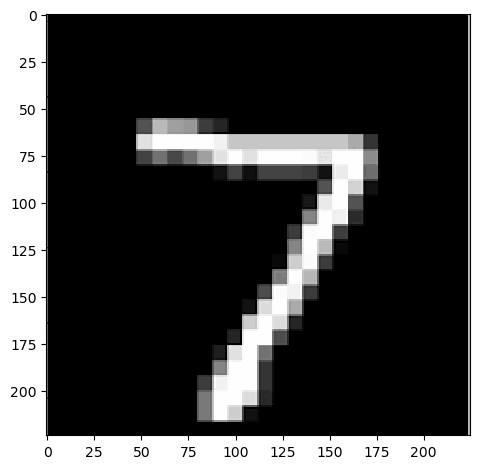

(28, 28)
Predictions:
tensor([[-2.0791, -0.1786, -1.2722,  2.8768, -2.6971, -2.6477, -7.3885, 10.9701,
         -3.6793, -1.1678]])

Predicted Number:7

(28, 28)


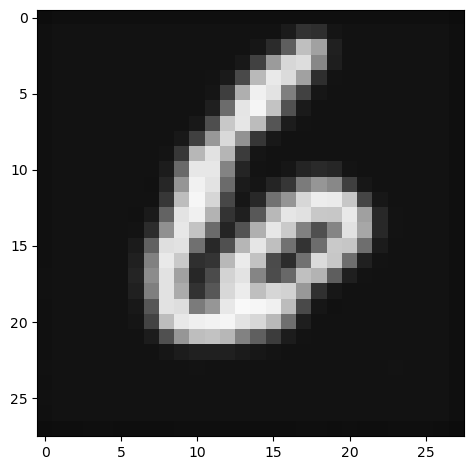

(28, 28)
Predictions:
tensor([[ 1.7635, -0.7858,  0.0465, -4.2916,  0.0250,  3.6601, 13.1906, -3.4005,
          3.9690, -1.3324]])

Predicted Number:6



In [22]:
# Feed new unseen images

pics = ['7.png','nr6.png']

count = 0

# Define the classes
classes = [0,1,2,3,4,5,6,7,8,9]

# Call the prediction function
for i in pics:
    classify(model,i,classes,count)
    count += 1

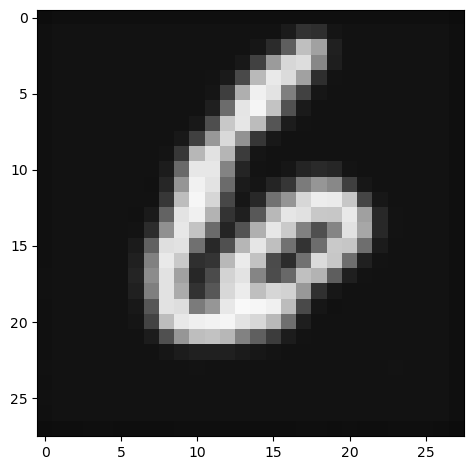

In [24]:
io.imshow('nr6.png')